In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')      
# !pip install transformers

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
from collections import defaultdict
from datetime import datetime
import fnmatch
import itertools
import matplotlib.pyplot as plt
import numpy as np
from numpy.random import RandomState
import os
from pdb import set_trace
import pandas as pd
import pickle
import pprint
import random
from sklearn.linear_model import SGDClassifier 
from sklearn.metrics import f1_score, confusion_matrix, roc_auc_score, auc, precision_recall_curve
from sklearn.metrics import precision_recall_fscore_support as score
import seaborn as sns
import warnings
import torch
import uuid
import time
import copy

import sys
sys.path.append("/content/drive/My Drive/collab/TADAT/") 
#local
from tadat.pipeline import plots
import tadat.core as core


warnings.filterwarnings("ignore")
sns.set(style="whitegrid")

## Configs

In [3]:

# BASE_PATH = "/content/drive/My Drive/collab/MIMIC/"
BASE_PATH = "/Users/samir/Dev/projects/MIMIC/MIMIC/"
INPUT_PATH = BASE_PATH+"/DATA/input/"
FEATURES_PATH = BASE_PATH+"/DATA/features/"
OUTPUT_PATH = BASE_PATH+"/DATA/results/"
TMP_PATH = BASE_PATH+"/DATA/processed/"

TUNE_OUTPUT_PATH = BASE_PATH+"/DATA/results_fine/"
TUNE_TMP_PATH = BASE_PATH+"/DATA/processed_fine/"

GRID_OUTPUT_PATH = BASE_PATH+"/DATA/results_grid/"
GRID_TMP_PATH = BASE_PATH+"/DATA/processed_grid/"

#configs
N_SEEDS=4
N_VAL_SEEDS = 5
N_VAL_RUNS = 25
N_TASKS = 3
N_TASKS = 50
# PLOT_VARS=["auroc","auprc","sensitivity","specificity"]
PLOT_VARS=["auroc","sensitivity"]
MODEL="BERT-POOL"
PLOT_VAR = "auroc"

GROUPS = { "GENDER": ["M","F"],   
         "ETHNICITY": ["WHITE","BLACK","ASIAN","HISPANIC"]
}

CLASSIFIER = 'sklearn'
CLASSIFIER = 'torch'
# CLASSIFIER = 'mseq'
CLINICALBERT = "emilyalsentzer/Bio_ClinicalBERT"

In [4]:

SMALL_SIZE = 13
MEDIUM_SIZE = 16
BIGGER_SIZE = 16

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title


# Modeling 

In [5]:
def train_classifier(X_train, Y_train, X_val, Y_val, 
                     init_seed, shuffle_seed=None, input_dimension=None):    
    if CLASSIFIER == "torch":        
        x = core.models.MyLinearModel(in_dim=input_dimension, out_dim=1, 
                    loss_fn=torch.nn.BCEWithLogitsLoss(), 
                    init_seed=init_seed, n_epochs=500, 
                    default_lr=0.1, batch_size=None, 
                    shuffle_seed=shuffle_seed, silent=True,
                    shuffle=True) 
        x.fit(X_train, Y_train, X_val, Y_val)
    elif CLASSIFIER == "mseq":        
        x = core.models.MultiSeqLinearModel(in_dim=input_dimension, out_dim=1, 
                    loss_fn=torch.nn.BCELoss(), 
                    init_seed=init_seed, n_epochs=500, 
                    default_lr=0.1, batch_size=None, 
                    shuffle_seed=shuffle_seed, silent=True,
                    shuffle=True) 
        x.fit(X_train, Y_train, X_val, Y_val)
    elif CLASSIFIER == "sklearn":
        x = SGDClassifier(loss="log", random_state=shuffle_seed)
        x.fit(X_train, Y_train)
    else:
        raise NotImplementedError
    return x

def evaluate_classifier(model, X_test, Y_test,
                   labels, model_name, random_seed, subgroup, res_path=None):
    Y_hat = model.predict(X_test)
    Y_hat_prob = model.predict_proba(X_test)
    #get probabilities for the positive class
    if CLASSIFIER == 'sklearn':
        Y_hat_prob = Y_hat_prob[:,labels[1]]    
    microF1 = f1_score(Y_test, Y_hat, average="micro") 
    macroF1 = f1_score(Y_test, Y_hat, average="macro") 
    try:
        aurocc = roc_auc_score(Y_test, Y_hat_prob)
    except ValueError:
        aurocc = 0
    try:
        prec, rec, thresholds = precision_recall_curve(Y_test, Y_hat_prob)       
        auprc = auc(rec, prec)
    except ValueError:
        auprc = 0
    try:
        tn, fp, fn, tp = confusion_matrix(Y_test, Y_hat).ravel()
        specificity = tn / (tn+fp)
        sensitivity = tp / (fn+tp)
    except ValueError:
        specificity, sensitivity = 0, 0
    
    res = {"model":model_name, 
            "seed":random_seed,  
            "group":subgroup,    
            "microF1":round(microF1,3),
            "macroF1":round(macroF1,3),
            "auroc":round(aurocc,3),
            "auprc":round(auprc,3),
            "specificity":round(specificity,3),
            "sensitivity":round(sensitivity,3)           
            }

    if res_path is not None:    
        core.helpers.save_results(res, res_path, sep="\t")
    return res



def vectorize(df_train, df_val, df_test, subject_ids):
    #vectorize labels
    train_Y = df_train["Y"]
    val_Y = df_val["Y"]           
    test_Y = df_test["Y"]           
    
    label_vocab = core.vectorizer.get_labels_vocab(train_Y+val_Y)
    train_Y,_ = core.vectorizer.label2idx(train_Y, label_vocab)
    val_Y,_ = core.vectorizer.label2idx(val_Y, label_vocab)
    test_Y,_ = core.vectorizer.label2idx(test_Y, label_vocab)
    
    
    #get the subject id indices
    train_idxs = [subject_ids.index(i) for i in list(df_train["SUBJECT_ID"])] 
    val_idxs = [subject_ids.index(i) for i in list(df_val["SUBJECT_ID"])] 
    test_idxs = [subject_ids.index(i) for i in list(df_test["SUBJECT_ID"])] 
    
    train = {}
    test = {}
    val = {}
    train["all"] = [train_idxs, train_Y]
    test["all"] = [test_idxs, test_Y]
    val["all"] = [val_idxs, val_Y]

    for group in list(GROUPS.keys()):
        #and subgroups
        for subgroup in GROUPS[group]:                
            df_train_sub = df_train[df_train[group] == subgroup]
            df_test_sub = df_test[df_test[group] == subgroup]
            df_val_sub = df_val[df_val[group] == subgroup]
            print("[subgroup: {} | tr: {} | ts: {} | val: {}]".format(subgroup, len(df_train_sub), len(df_test_sub), len(df_val_sub)))
            #vectorize labels               
            train_Y_sub,_ = core.vectorizer.label2idx(df_train_sub["Y"], label_vocab)            
            test_Y_sub,_ = core.vectorizer.label2idx(df_test_sub["Y"], label_vocab)            
            val_Y_sub,_ = core.vectorizer.label2idx(df_val_sub["Y"], label_vocab)            

            #get indices into the feature matrix
            train_idxs_sub = [subject_ids.index(i) for i in list(df_train_sub["SUBJECT_ID"])] 
            test_idxs_sub = [subject_ids.index(i) for i in list(df_test_sub["SUBJECT_ID"])] 
            val_idxs_sub = [subject_ids.index(i) for i in list(df_val_sub["SUBJECT_ID"])] 
            if subgroup == "M":
                subgroup = "men"
            elif subgroup == "F":
                subgroup = "women"
            train[subgroup.lower()] = [train_idxs_sub, train_Y_sub]
            test[subgroup.lower()] = [test_idxs_sub, test_Y_sub]
            val[subgroup.lower()] = [val_idxs_sub, val_Y_sub]

    return train, val, test, label_vocab


def get_features(data, vocab_size, feature_type, word_vectors=None):
    if feature_type == "BOW-BIN":
        X = core.features.BOW(data, vocab_size,sparse=True)
    elif feature_type == "BOW-FREQ":
        X = core.features.BOW_freq(data, vocab_size,sparse=True)
    elif feature_type == "BOE-BIN":
        X = core.features.BOE(data, word_vectors,"bin")
    elif feature_type == "BOE-SUM": 
        X = core.features.BOE(data, word_vectors,"sum")
    elif feature_type == "BERT-POOL":
        X =  core.transformer_encoders.encode_sequences(data, batchsize=64)        
    elif feature_type == "BERT-CLS":
        X =  core.transformer_encoders.encode_sequences(data, cls_features=True,
                                                        batchsize=64)            
    elif feature_type == "MULTI-BERT-POOL":
        X =  core.transformer_encoders.encode_multi_sequences(data, 10, batchsize=32,
                                                         tmp_path=TMP_PATH)
    elif feature_type == "MULTI-BERT-CLS":
        X =  core.transformer_encoders.encode_multi_sequences(data, 10, 
                                                         cls_features=True,
                                                         batchsize=32,
                                                         tmp_path=TMP_PATH)
    elif feature_type == "CLINICALBERT-POOL":
        tokenizer, encoder = core.transformer_encoders.get_encoder(CLINICALBERT)
        X =  core.transformer_encoders.encode_sequences(data, batchsize=64, tokenizer=tokenizer,
                                                                    encoder=encoder)        
    elif feature_type == "CLINICALBERT-CLS":
        tokenizer, encoder = core.transformer_encoders.get_encoder(CLINICALBERT)
        X =  core.transformer_encoders.encode_sequences(data, cls_features=True,batchsize=64,
                                                                    tokenizer=tokenizer, encoder=encoder)        
    elif feature_type == "CLINICALMULTI-BERT-POOL":
        tokenizer, encoder = core.transformer_encoders.get_encoder(CLINICALBERT)
        X =  core.transformer_encoders.encode_multi_sequences(data, 10, batchsize=32,tmp_path=TMP_PATH,
                                                              tokenizer=tokenizer, encoder=encoder)
    elif feature_type == "CLINICALMULTI-BERT-CLS":
        tokenizer, encoder = core.transformer_encoders.get_encoder(CLINICALBERT)
        X =  core.transformer_encoders.encode_multi_sequences(data, 10, cls_features=True, 
                                                                batchsize=32,tmp_path=TMP_PATH,
                                                                tokenizer=tokenizer, encoder=encoder)
    else:
        raise NotImplementedError
    return X

def extract_features(feature_type, path):
    X = read_cache(path+"feats_{}".format(feature_type))
    if X:
        print("[reading cached features]")
        subject_ids, X_feats = X
    else:
        print("[computing {} features]".format(feature_type))
        df = pd.read_csv(path+"patients.csv", sep="\t", header=0)
        subject_ids = list(df["SUBJECT_ID"])
        docs = list(df["TEXT"])
        if "BERT" in feature_type:
            X_feats = get_features(docs, None, feature_type)
        else:
            X, word_vocab = core.vectorizer.docs2idx(docs)
            X_feats = get_features(X,len(word_vocab),feature_type)
        #save features
        print("[saving features]")
        write_cache(path+"feats_{}".format(feature_type), 
                    [subject_ids, X_feats])
    return subject_ids, X_feats



# Run

In [6]:
def read_dataset(path, dataset_name, df_patients):    
    df_train = pd.read_csv("{}/{}_train.csv".format(path, dataset_name), 
                           sep="\t", header=0)
    df_test  = pd.read_csv("{}/{}_test.csv".format(path, dataset_name),
                           sep="\t", header=0)
    df_val   = pd.read_csv("{}/{}_val.csv".format(path, dataset_name),
                           sep="\t", header=0)
    #set indices
    df_patients.set_index("SUBJECT_ID", inplace=True)
    df_train.set_index("SUBJECT_ID", inplace=True)
    df_test.set_index("SUBJECT_ID", inplace=True)
    df_val.set_index("SUBJECT_ID", inplace=True)

    df_train = df_train.join(df_patients, on="SUBJECT_ID", 
                             how="inner", lsuffix="N_").reset_index()
    df_test = df_test.join(df_patients, on="SUBJECT_ID", 
                           how="inner", lsuffix="N_").reset_index()
    df_val = df_val.join(df_patients, on="SUBJECT_ID", 
                         how="inner", lsuffix="N_").reset_index()

    return df_train, df_test, df_val   


def read_cache(path):
    X = None
    try:
        with open(path, "rb") as fi:            
            X = pickle.load(fi)
    except FileNotFoundError:
        pass
    return X

def write_cache(path, o):
    dirname = os.path.dirname(path)
    if not os.path.exists(dirname):
        os.makedirs(dirname)
    with open(path, "wb") as fo:
        pickle.dump(o, fo)
        
def clear_cache(cache_path, model="*", dataset="*", group="*", ctype="*"):
    assert ctype in ["*","res*","feats"]
    file_paths = os.listdir(cache_path)
    pattern = "{}_{}_{}_*_{}.pkl".format(dataset, model, group, ctype).lower()
    for fname in file_paths:
        if fnmatch.fnmatch(fname, pattern):
            os.remove(cache_path+"/"+fname)
            print("cleared file: {}".format(fname))      

# def run(data_path, dataset, features_path, feature_type, cache_path):
#     #read patients data
#     df_patients = pd.read_csv(features_path+"patients.csv", 
#                               sep="\t", header=0).drop(columns=["TEXT"])

#     df_train, df_test, df_val = read_dataset(data_path, dataset, df_patients)
    
#     print("[train/test set size: {}/{}]".format(len(df_train), len(df_test)))
#     print("[{} classifier]".format(CLASSIFIER))
#     subject_ids, feature_matrix = extract_features(feature_type, features_path)      
#     train, val, test, label_vocab = vectorize(df_train, df_val, df_test, subject_ids)
#     train_idx, train_Y = train["all"]
#     val_idx, val_Y = val["all"]
#     #slice the feature matrix to get the corresponding instances
#     train_X = feature_matrix[train_idx, :]    
#     val_X = feature_matrix[val_idx, :]    
#     random.seed(1) #ensure repeateable runs 
#     random_seeds = random.sample(range(0, 10000), N_SEEDS)        
#     incremental_results = {}     
#     ##train/test classifier for each random seed pair
#     for init_seed, shuffle_seed in itertools.product(random_seeds,repeat=2):        
#         seed = "{}x{}".format(init_seed, shuffle_seed)
#         res_fname = "{}_{}_res{}.pkl".format(dataset, feature_type, seed).lower()                
#         #look for cached results
#         curr_results = None
#         if cache_path: curr_results = read_cache(cache_path+res_fname)              
#         if not curr_results:
#             curr_results = {}
#             print(" > seed: {}".format(seed))                        
#             model = train_classifier(train_X, train_Y,val_X, val_Y,  
#                                      input_dimension=train_X.shape[-1],
#                                      init_seed=init_seed, 
#                                      shuffle_seed=shuffle_seed)                                                      
#             #test each subgroup (note thtat *all* is also a subgroup)
#             for subgroup in test.keys():                                
#                 test_idx_sub, test_Y_sub = test[subgroup]                 
#                 test_X_sub = feature_matrix[test_idx_sub, :]                
#                 res_sub = evaluate_classifier(model, test_X_sub, test_Y_sub, 
#                                             label_vocab, feature_type, seed, subgroup)                
#                 curr_results[subgroup]= res_sub               
#             #cache results
#             if cache_path: write_cache(cache_path+res_fname, curr_results)                
#         else:
#             print("loaded cached results | seed: {}".format(seed))        
        
#         incremental_results = merge_results(curr_results, incremental_results, 
#                                             list(test.keys()))
#     #build dataframes 
#     df_results = results_to_df(incremental_results, test.keys())
#     return df_results





# def tune_run(data_path, dataset, features_path, feature_type, cache_path, tune_metric, fairness=False):
#     df_patients = pd.read_csv(features_path+"patients.csv", 
#                               sep="\t", header=0).drop(columns=["TEXT"])
#     df_train, df_test, df_val = read_dataset(data_path, dataset, df_patients)
#     print("[train/test set size: {}/{}]".format(len(df_train), len(df_test)))
#     print("[{} classifier]".format(CLASSIFIER))
#     subject_ids, feature_matrix = extract_features(feature_type, features_path)
#     train, val, test, label_vocab = vectorize(df_train, df_val, df_test, subject_ids)
#     train_idx, train_Y = train["all"]
#     #slice the feature matrix to get the corresponding instances
#     train_X = feature_matrix[train_idx, :]    
#     random.seed(1) #ensure repeateable runs 
#     random_seeds = random.sample(range(0, 10000), N_VAL_RUNS*N_VAL_SEEDS)        
#     incremental_results = {}     
    
#     for i in range(N_VAL_RUNS):        
#         res_fname = "{}_{}_tuned_res{}.pkl".format(dataset, feature_type, i).lower()
#         #look for cached results
#         curr_results = None
#         if cache_path: curr_results = read_cache(cache_path+res_fname)              
#         if not curr_results:
#             curr_results = {}
#             seeds = random_seeds[i*N_VAL_SEEDS:(i+1)*N_VAL_SEEDS]
#             if fairness:
#                 model, perf, best_seed, val_run = tune_fair_classifier(train_X, train_Y, 
#                                                               val, feature_matrix, label_vocab,
#                                                               feature_type, seeds, tune_metric)               
#             else:
#                 model, perf, best_seed, val_run = tune_classifier(train_X, train_Y, 
#                                                               val, feature_matrix, label_vocab,
#                                                               feature_type, seeds, tune_metric)               

#             print("[seed: {}| {}: {}]".format(best_seed, tune_metric, round(perf,3)))    
                                                    
#             #test each subgroup (note thtat *all* is also a subgroup)
#             for subgroup in test.keys():                                
#                 test_idx_sub, test_Y_sub = test[subgroup]                 
#                 test_X_sub = feature_matrix[test_idx_sub, :]                
#                 res_sub = evaluate_classifier(model, test_X_sub, test_Y_sub, 
#                                             label_vocab, feature_type, best_seed, subgroup)                
#                 curr_results[subgroup]= res_sub               
#             #cache results
#             if cache_path: write_cache(cache_path+res_fname, curr_results)                
#         else:
#             print("loaded cached results | run: {}".format(i))        
        
#         incremental_results = merge_results(curr_results, incremental_results, 
#                                             list(test.keys()))
#     #build dataframes 
#     df_results = results_to_df(incremental_results, test.keys())
#     return df_results

# def merge_results(curr_results, results, subgroups):
#     #append results    
#     for subgroup in subgroups:                
#         res = curr_results[subgroup]
#         try:
#             results[subgroup].append(res)            
#         except KeyError:
#             results[subgroup] = []
#             results[subgroup].append(res)            
#     return results

# def results_to_df(results, subgroups):
#     df_results = {}
#     df_res = pd.DataFrame(results["all"])            
#     for subgroup in subgroups:        
#         # if subgroup == "all": continue
#         df_res_g = pd.DataFrame(results[subgroup])        
#         df_res_delta = df_res_g.sub(df_res.iloc[:,3:])
#         # from pdb import set_trace; set_trace()
#         df_res_delta["model"] = df_res_g["model"]
#         df_res_delta["seed"] = df_res_g["seed"]
#         df_res_delta["group"] = df_res_g["group"] 
#         df_results[subgroup] = {}
#         df_results[subgroup]["results"] = df_res_g
#         df_results[subgroup]["delta"] = df_res_delta
        
#     return dict(df_results)

def subsample_run(data_path, dataset, features_path, feature_type, cache_path, n_draws=10):
    #read patients data
    df_patients = pd.read_csv(features_path+"patients.csv", 
                              sep="\t", header=0).drop(columns=["TEXT"])

    df_train, df_test, df_val = read_dataset(data_path, dataset, df_patients)
    
    print("[train/test set size: {}/{}]".format(len(df_train), len(df_test)))
    print("[{} classifier]".format(CLASSIFIER))
    subject_ids, feature_matrix = extract_features(feature_type, features_path)      
    train, val, test, label_vocab = vectorize(df_train, df_val, df_test, subject_ids)
    train_idx, train_Y = train["all"]
    val_idx, val_Y = val["all"]
    #slice the feature matrix to get the corresponding instances
    train_X = feature_matrix[train_idx, :]    
    val_X = feature_matrix[val_idx, :]    
    random.seed(1) #ensure repeateable runs 
    random_seeds = random.sample(range(0, 10000), N_SEEDS)        
    incremental_results = {}     
    sample_size = min([len(test[subgroup][0]) for subgroup in test.keys()])
    print(sample_size)
    ##train/test classifier for each random seed pair    
    for init_seed, shuffle_seed in itertools.product(random_seeds,repeat=2):        
        seed = "{}x{}".format(init_seed, shuffle_seed)
        res_fname = "{}_{}_res{}.pkl".format(dataset, feature_type, seed).lower()                        
        curr_results = {}
        print(" > seed: {}".format(seed))                        
        model = train_classifier(train_X, train_Y,val_X, val_Y,  
                                    input_dimension=train_X.shape[-1],
                                    init_seed=init_seed, 
                                    shuffle_seed=shuffle_seed)                                                      
        for i in range(n_draws):
            #evaluate different random samples of the data
            #test each subgroup (note thtat *all* is also a subgroup)            
            for subgroup in test.keys():                                
                test_idx_sub, test_Y_sub = test[subgroup]            
                test_Y_sub = np.array(test_Y_sub)
                test_idx_sub = np.array(test_idx_sub)                    
                random_sample = random.sample(range(len(test_idx_sub)), sample_size)                
                test_Y_sub_sample = test_Y_sub[random_sample]
                test_idx_sub_sample = test_idx_sub[random_sample]                    
                test_X_sub_sample = feature_matrix[test_idx_sub_sample, :]                
                res_sub = evaluate_classifier(model, test_X_sub_sample, test_Y_sub_sample, 
                                            label_vocab, feature_type, seed+"x"+str(i), subgroup)                
                curr_results[subgroup]= res_sub                       
        
            incremental_results = merge_results(curr_results, incremental_results, 
                                            list(test.keys()))
    #build dataframes 
    df_results = results_to_df(incremental_results, test.keys())
    return df_results


# Analyses

In [29]:
def run_analyses(data_path, dataset, features_path, feature_type, results_path, 
                 cache_path, metric, tuning, clear_results=False):    

    if not os.path.exists(results_path): os.makedirs(results_path)  
    if not os.path.exists(cache_path): os.makedirs(cache_path)  
    if clear_results:
        clear_cache(cache_path, model=feature_type, dataset=dataset, ctype="res*")
    if tuning: 
        best_seeds = grid_search(data_path, dataset, features_path, feature_type, cache_path, metric)  
        df_results = test_seeds(data_path, dataset, features_path, feature_type, results_path, metric, best_seeds) 
        best_seeds = best_seeds.set_index("seed")
        df_results = df_results.set_index("seed")
        df_results = best_seeds.join(df_results, how="inner", on=["seed"])
        df_results = df_results.sort_values(by=["criterion","k"])
        fname = "{}_{}_{}_tuned.csv".format(dataset, feature_type, metric).lower()            
    else:
        df_results = run2(data_path, dataset, features_path, feature_type, cache_path, metric)         
        fname = "{}_{}_{}.csv".format(dataset, feature_type, metric).lower()
    
    df_results.to_csv(results_path+fname, index=False, header=True)
    return df_results               

#Run All the tasks
def run_tasks(data_path, tasks_fname, features_path, feature_type, results_path, cache_path,  
             metric, tuning=False, reset=False, mini_tasks=True):
    #if reset delete the completed tasks file
    if reset: reset_tasks(cache_path)    
    with open(data_path+tasks_fname,"r") as fid:
        for i,l in enumerate(fid):
            if i > N_TASKS: break
            fname, task_name = l.strip("\n").split(",")            
            dataset = "mini-"+fname if mini_tasks else fname
            # dataset = fname
            if is_task_done(cache_path, dataset): 
                print("[dataset: {} already processed]".format(dataset))
                continue                        
            print("******** {} {} ********".format(task_name, dataset))      
            run_analyses(data_path, dataset, features_path, feature_type, results_path, 
                         cache_path, metric=metric, tuning=tuning, clear_results=False)
            task_done(cache_path, dataset)

def task_done(path,  task):
    dirname = os.path.dirname(path)
    if not os.path.exists(dirname):
        os.makedirs(dirname)
    with open(path+"completed_tasks.txt", "a") as fod:
        fod.write(task+"\n")

def reset_tasks(path):
    dirname = os.path.dirname(path)
    if not os.path.exists(dirname):
        os.makedirs(dirname)
    with open(path+"completed_tasks.txt", "w") as fod:
        fod.write("")

def is_task_done(path,  task):
    try:
        with open(path+"completed_tasks.txt", "r") as fid:
            tasks = fid.read().split("\n")            
        return task in set(tasks)
    except FileNotFoundError:
        #create file if not found
        dirname = os.path.dirname(path)
        if not os.path.exists(dirname):
            os.makedirs(dirname)
        with open(path+"completed_tasks.txt", "w") as fid:
            fid.write("")
        return False

def plot_densities(df, ax, title):
    ax.set_title(title)
    for y in PLOT_VARS:        
        try:
            df.plot.kde(ax=ax, x="seed", y=y)
        except:
            pass

# def plot_scatters(results, metric, title):
#     n_rows=2
#     n_cols = 3    
#     fig, ax = plt.subplots(n_rows, n_cols,  figsize=(12,5), sharex=True, sharey=True)
#     #current coloramap
#     cmap = plt.rcParams['axes.prop_cycle'].by_key()['color']
#     coords = list(itertools.product(range(n_rows),range(n_cols)))   
#     subgroups = list(results.keys())
#     subgroups.remove('all')
#     df = results['all']["results"]
#     for subgroup, col, coord in zip(subgroups, cmap, coords ):
#         df_delta = results[subgroup]["delta"]        
#         df_all = df.merge(df_delta, on=["model","seed"],
#                                       suffixes=[None, "_delta"])
#         #get absolute values for the deltas    
#         df_all[metric+"_delta"] = df_all[metric+"_delta"].abs() 
#         df_all.plot.scatter(x=metric,y=metric+"_delta",
#                             c=col, ax=ax[coord[0]][coord[1]])
#         z = np.polyfit(df_all[metric], df_all[metric+"_delta"], 1)
#         y_hat = np.poly1d(z)(df_all[metric])
#         ax[coord[0]][coord[1]].plot(df_all[metric], y_hat, c=col, lw=1)
#         ax[coord[0]][coord[1]].set_title(subgroup)
#         ax[coord[0]][coord[1]].set_ylabel("delta")
#     fig.suptitle(title, y=1.02)
#     plt.tight_layout()
    
# def plot_deltas(results, metric, title):
#     df_delta = pd.concat([results[g]["delta"] for g in list(results.keys()) if g != "all"])    
#     #transform results into "long format"
#     df_delta_long = df_delta.melt(id_vars=["seed","model","group"], 
#                                   value_vars=[metric], 
#                                   var_name="metric", value_name="delta")
#     set_trace()
#     g = sns.catplot(x="group", y="delta", data=df_delta_long, 
#                     sharey=True,legend=False)    
#     lim = max(df_delta_long["delta"].abs()) + 0.05
    
#     for ax in g.axes[0]:
#         ax.axhline(0, ls='--',c="r")
#     plt.suptitle(title, y=1.02)
#     plt.tight_layout()
#     plt.show()  

def plot_analyses(results_path, dataset, task_name, feature_type, metric):

    fname = "{}_{}_{}.csv".format(dataset, feature_type, metric).lower()       
    try:
        df_results = pd.read_csv(results_path+fname)            
        plot_minority_gaps(df_results, task_name)
        plot_minority_scatters(df_results, task_name)        
    except FileNotFoundError:
        print("{} not found...".format(fname))
        # plot_scatters(df_results, plot_metric, task_name)
        # plot_deltas(df_results, plot_metric, task_name)


def plot_tasks(tasks_fname, feature_type, results_path, metric, mini_tasks=True):
    with open(tasks_fname,"r") as fid:        
        for i,l in enumerate(fid):            
            fname, task_name = l.strip("\n").split(",")
            dataset = "mini-"+fname if mini_tasks else fname
            plot_analyses(results_path, dataset, task_name, feature_type, metric)

    # plot_gaps(tasks_fname, feature_type, results_path, mini_tasks=mini_tasks, 
    #           plot_metric=plot_metric, tune_metric=tune_metric)
    # plot_performances(tasks_fname, feature_type, results_path, mini_tasks=mini_tasks, 
    #           plot_metric=plot_metric, tune_metric=tune_metric)

def get_gaps(results, dataset_name, metric):    
    all_dfs = [results[g]["results"][["seed", metric]] for g in results.keys()]
    all_dfs = pd.concat(all_dfs)
    diff_df = (all_dfs.groupby("seed").max() - all_dfs.groupby("seed").min()).reset_index()
    diff_df["dataset"] = [dataset_name]*len(diff_df)
    return diff_df

def plot_gaps(tasks_fname, feature_type, results_path, 
               mini_tasks=True, plot_metric=None, tune_metric=None):
    dfs = []
    with open(tasks_fname,"r") as fid:        
        for i,l in enumerate(fid):            
            task_abv, task_name = l.strip("\n").split(",")
            dataset = "mini-"+task_abv if mini_tasks else task_abv
            if tune_metric:
                fname = "{}_{}_all_tuned_res.pkl".format(dataset, feature_type).lower()
            else:        
                fname = "{}_{}_all_res.pkl".format(dataset, feature_type).lower()

            df_results = read_cache(results_path+fname)    

            if df_results:
                df_gaps = get_gaps(df_results, task_abv, plot_metric)
                dfs.append(df_gaps)
    dfs = pd.concat(dfs)
    cmap = plt.rcParams['axes.prop_cycle'].by_key()['color']
    g = sns.catplot(x=plot_metric,y="dataset", data=dfs, sharey=True,legend=True, 
                    legend_out=True, height=6, aspect=0.85,palette=cmap)        
    g.set_xlabels(plot_metric + " gap")
    plt.tight_layout()
    plt.show()  
    
def plot_performances(tasks_fname, feature_type, results_path, 
               mini_tasks=True, plot_metric=None, tune_metric=None):
    dfs = []
    with open(tasks_fname,"r") as fid:        
        for i,l in enumerate(fid):            
            task_abv, task_name = l.strip("\n").split(",")
            dataset = "mini-"+task_abv if mini_tasks else task_abv
            if tune_metric:
                fname = "{}_{}_all_tuned_res.pkl".format(dataset, feature_type).lower()
            else:        
                fname = "{}_{}_all_res.pkl".format(dataset, feature_type).lower()

            df_results = read_cache(results_path+fname)    
            if df_results:
                df = df_results["all"]["results"]
                df["dataset"] = [task_abv]*len(df)
                dfs.append(df)
    dfs = pd.concat(dfs)
    cmap = plt.rcParams['axes.prop_cycle'].by_key()['color']
    g = sns.catplot(x=plot_metric,y="dataset", data=dfs, sharey=True,legend=True, 
                    legend_out=True, height=6, aspect=0.85,palette=cmap)        
#     g.set_xlabels(plot_metric + " gap")
    plt.tight_layout()
    plt.show()  

In [20]:
def grid_search(data_path, dataset, features_path, feature_type, cache_path, tune_metric, n_runs=300):
    #read patients data
    df_patients = pd.read_csv(features_path+"patients.csv", 
                              sep="\t", header=0).drop(columns=["TEXT"])

    df_train, df_test, df_val = read_dataset(data_path, dataset, df_patients)    
    print("[train/test set size: {}/{}]".format(len(df_train), len(df_test)))
    print("[grid searching with {} classifier]".format(CLASSIFIER))
    subject_ids, feature_matrix = extract_features(feature_type, features_path)      
    train, val, test, label_vocab = vectorize(df_train, df_val, df_test, subject_ids)
    train_idx, train_Y = train["all"]
    val_idx, val_Y = val["all"]
    #slice the feature matrix to get the corresponding instances
    train_X = feature_matrix[train_idx, :]    
    val_X = feature_matrix[val_idx, :]    

    init_randomizer = RandomState(1)
    shuffle_randomizer = RandomState(2)    
    results = []
    dirname = os.path.dirname(cache_path)
    if not os.path.exists(dirname):
        os.makedirs(dirname)
    res_fname = cache_path+"/grid_{}_{}_{}.pkl".format(dataset, feature_type, tune_metric).lower()    
    try:
        df_results = pd.read_csv(res_fname)
    except FileNotFoundError:
        df_results = pd.DataFrame(columns = ["seed"] +  list(val.keys()))
        df_results.to_csv(res_fname, index=False, header=True)        
    groups = list(val.keys())
    skip_seeds = set(df_results["seed"])
    ##train/test classifier for each random seed pair
    for j in range(n_runs):         
        init_seed = init_randomizer.randint(10000)
        shuffle_seed = shuffle_randomizer.randint(10000)
        seed = "{}x{}".format(init_seed, shuffle_seed)        
        if seed in skip_seeds:
            print("skipped seed: {}".format(seed))
            continue
        curr_results = {"seed":seed}
        print(" > seed: {}".format(seed))                        
        model = train_classifier(train_X, train_Y,val_X, val_Y,  
                                    input_dimension=train_X.shape[-1],
                                    init_seed=init_seed, 
                                    shuffle_seed=shuffle_seed)                                                                
        ####### VALIDATION ########
        
        #test each subgroup (note thtat *all* is also a subgroup)
        for subgroup in groups:                                
            val_idx_sub, val_Y_sub = val[subgroup]                 
            val_X_sub = feature_matrix[val_idx_sub, :]                
            res_sub = evaluate_classifier(model, val_X_sub, val_Y_sub, 
                                        label_vocab, feature_type, seed, subgroup)                
            curr_results[subgroup]= res_sub[tune_metric]          

        df_results = df_results.append(curr_results, ignore_index=True)
        df_results.to_csv(res_fname, index=False, header=True)    
        
    #return the best seeds    
    return get_best_seeds(df_results, groups)

def run2(data_path, dataset, features_path, feature_type, cache_path, metric, n_seeds=N_SEEDS):
    #read patients data
    df_patients = pd.read_csv(features_path+"patients.csv", 
                              sep="\t", header=0).drop(columns=["TEXT"])

    df_train, df_test, df_val = read_dataset(data_path, dataset, df_patients)
    
    print("[train/test set size: {}/{}]".format(len(df_train), len(df_test)))
    print("[running 2 {} classifier]".format(CLASSIFIER))
    subject_ids, feature_matrix = extract_features(feature_type, features_path)      
    train, val, test, label_vocab = vectorize(df_train, df_val, df_test, subject_ids)
    train_idx, train_Y = train["all"]
    val_idx, val_Y = val["all"]
    #slice the feature matrix to get the corresponding instances
    train_X = feature_matrix[train_idx, :]    
    val_X = feature_matrix[val_idx, :]    
    
    dirname = os.path.dirname(cache_path)
    if not os.path.exists(dirname):
        os.makedirs(dirname)
    res_fname = cache_path+"/seeds_{}_{}_{}.pkl".format(dataset, feature_type, metric).lower()    
    try:
        df_results = pd.read_csv(res_fname)
    except FileNotFoundError:
        df_results = pd.DataFrame(columns = ["seed"] +  list(val.keys()))
        df_results.to_csv(res_fname, index=False, header=True)        
    groups = list(val.keys())
    skip_seeds = set(df_results["seed"])

    random.seed(1) #ensure repeateable runs 
    random_seeds = random.sample(range(0, 10000), n_seeds)        
    incremental_results = {}     
    ##train/test classifier for each random seed pair
    for init_seed, shuffle_seed in itertools.product(random_seeds,repeat=2):        
        seed = "{}x{}".format(init_seed, shuffle_seed)          
        if seed in skip_seeds:
            print("skipped seed: {}".format(seed))
            continue
        curr_results = {"seed":seed}
        print(" > seed: {}".format(seed))                        
        model = train_classifier(train_X, train_Y,val_X, val_Y,  
                                    input_dimension=train_X.shape[-1],
                                    init_seed=init_seed, 
                                    shuffle_seed=shuffle_seed)                                                                                
        #test each subgroup (note thtat *all* is also a subgroup)
        for subgroup in groups:                                
            test_idx_sub, test_Y_sub = test[subgroup]                 
            test_X_sub = feature_matrix[test_idx_sub, :]                
            res_sub = evaluate_classifier(model, test_X_sub, test_Y_sub, 
                                        label_vocab, feature_type, seed, subgroup)                
            curr_results[subgroup]= res_sub[metric]     

        df_results = df_results.append(curr_results, ignore_index=True)
        df_results.to_csv(res_fname, index=False, header=True)

    return df_results

def get_best_seeds(df_grid, groups, k=20):    

    groups.remove("all")    
    for g in groups:
        df_grid["delta_"+g] = (df_grid["all"] - df_grid[g]).abs()    
    
    df_grid["perf_avg"] = df_grid[[g for g in groups]].mean(axis=1)
    df_grid["perf_std"] = df_grid[[g for g in groups]].std(axis=1)
    df_grid["perf_avg_std"] = df_grid["perf_avg"] - df_grid["perf_std"]
    df_grid["delta_avg"] = df_grid[["delta_"+g for g in groups]].mean(axis=1)
    df_grid["perf_avg_delta"] = df_grid["perf_avg"] - df_grid["delta_avg"]
    df_grid["all_avg_delta"] = df_grid["all"] - df_grid["delta_avg"]

    z = int(len(df_grid)/k)+1
    res = []
    for i in range(z):
        step = (i+1)*k
        df = df_grid.iloc[:step,:]      
        #get the seed with the minimum delta
        best_df = df.iloc[df["delta_avg"].idxmin()]
        seed = best_df["seed"]
        perf = best_df["delta_avg"]
        res.append({"seed":seed, "criterion":"delta_avg", "k":step, "val":perf })        
        #get seeds with max criteria       
        for crit in ["all", "perf_avg", "perf_avg_std", "perf_avg_delta",
                     "all_avg_delta"]:        
            best_df = df.iloc[df[crit].idxmax()]
            seed = best_df["seed"]
            perf = best_df[crit]
            res.append({"seed":seed, "criterion":crit, "k":step, "val":perf })        
        df_best_seeds = pd.DataFrame(res)       
        
    return df_best_seeds


def test_seeds(data_path, dataset, features_path, feature_type, cache_path, metric, best_seeds):
    #read patients data
    df_patients = pd.read_csv(features_path+"patients.csv", 
                              sep="\t", header=0).drop(columns=["TEXT"])

    df_train, df_test, df_val = read_dataset(data_path, dataset, df_patients)    
    print("[train/test set size: {}/{}]".format(len(df_train), len(df_test)))
    print("[testing seeds with {} classifier]".format(CLASSIFIER))
    subject_ids, feature_matrix = extract_features(feature_type, features_path)      
    train, val, test, label_vocab = vectorize(df_train, df_val, df_test, subject_ids)
    train_idx, train_Y = train["all"]
    val_idx, val_Y = val["all"]
    #slice the feature matrix to get the corresponding instances
    train_X = feature_matrix[train_idx, :]    
    val_X = feature_matrix[val_idx, :]    
    groups = list(val.keys())
    dirname = os.path.dirname(cache_path)
    if not os.path.exists(dirname):
        os.makedirs(dirname)
    res_fname = cache_path+"/test_seeds_{}_{}_{}.pkl".format(dataset, feature_type, metric).lower()                    
    try:
        df_results = pd.read_csv(res_fname)
    except FileNotFoundError:
        cols = ["seed"] +  groups + ["delta_"+g for g in groups]
        df_results = pd.DataFrame(columns = cols)    
    skip_seeds = set(df_results["seed"])    
    for seed in set(best_seeds["seed"]):
        if seed in skip_seeds:
            print("skipped seed: {}".format(seed))
            continue 
        curr_results = {"seed":seed}
        print(" > seed: {}".format(seed))                        
        init_seed, shuffle_seed = seed.split("x") 
        model = train_classifier(train_X, train_Y,val_X, val_Y,  
                                    input_dimension=train_X.shape[-1],
                                    init_seed=int(init_seed), 
                                    shuffle_seed=int(shuffle_seed))
        ####### TEST ########
        
        #test each subgroup (note thtat *all* is also a subgroup)
        for subgroup in test.keys():                                
            test_idx_sub, test_Y_sub = test[subgroup]                 
            test_X_sub = feature_matrix[test_idx_sub, :]                
            res_sub = evaluate_classifier(model, test_X_sub, test_Y_sub, 
                                        label_vocab, feature_type, seed, subgroup)                
            curr_results[subgroup]= res_sub[metric]          

        df_results = df_results.append(curr_results, ignore_index=True)
    
    for g in groups:
        df_results["delta_"+g] = (df_results["all"] - df_results[g]).abs()    
        
    df_results["avg_delta_test"] = df_results[["delta_"+g for g in groups]].mean(axis=1)
    df_results.to_csv(res_fname,index=False, header=True)
    
    return df_results

def plot_gridsearch(cache_path, dataset, feature_type, tune_metric, title, subgroups=False, delta=False):    
    res_fname = cache_path+"{}_{}_{}_all_tuned.csv".format(dataset, feature_type, tune_metric).lower()              
    df_results = pd.read_csv(res_fname)  
    df_all = df_results[df_results["criterion"] == "all"]    
    if delta:
        last_all = df_all.iloc[df_all["k"].idxmax()]["avg_delta_test"]
        best_all = df_all.iloc[df_all["avg_delta_test"].idxmin()]["avg_delta_test"]    
    else:
        last_all = df_all.iloc[df_all["k"].idxmax()]["all"]    
        best_all = df_all.iloc[df_all["all"].idxmax()]["all"]    
    cmap = plt.rcParams['axes.prop_cycle'].by_key()['color']
#     criteria = ["all", "perf_avg", "perf_avg_std", "delta_avg", "perf_avg_delta"]
    criteria = ["all","perf_avg", "all_avg_delta", "perf_avg_delta"]
    crit_labels = ["performance","subgroup avg", "performance - avg subgroup delta", "subgroup avg - avg subgroup delta"]
#     set_trace()
    groups = ["all", "men", "women", "white", "black","asian", "hispanic"]
    fig, ax = plt.subplots(1, len(criteria),  figsize=(25,8), sharex=True, sharey=True)    
    if delta:
        groups = ["delta_" + l for l in groups]
    for i in range(len(criteria)):
        df = df_results[df_results["criterion"] == criteria[i]]    
        ax[i].set_title(crit_labels[i])
        if delta:
            ax[i].axhline(best_all, linewidth=3, c="gray", linestyle="--")
            ax[i].axhline(last_all, linewidth=2, c="gray", linestyle="--")
            df.plot(x="k", y="avg_delta_test",   linewidth=4, ax=ax[i], c="gray")    
        else:
            ax[i].axhline(best_all, linewidth=3, c=cmap[0], linestyle="--")
            ax[i].axhline(last_all, linewidth=2, c=cmap[0], linestyle="--")
            df.plot(x="k", y="all",   linewidth=4, ax=ax[i])    
        #plot indiv
        if subgroups:
            for g in groups[1:]:
                df.plot(x="k", y=g, ax=ax[i])
            
        #place legend on the last subplot
        if i == len(criteria)-1: 
            ax[i].legend(bbox_to_anchor=(1.05, 0), loc='lower left', borderaxespad=0.)
        else:
            ax[i].get_legend().remove()
    
    plt.tight_layout()
    plt.show()
        
def plot_gridsearches(tasks_fname, results_path, feature_type, 
               mini_tasks=True, metric=None, subgroups=False):
    with open(tasks_fname,"r") as fid:        
        for i,l in enumerate(fid):     
            fname, task_name = l.strip("\n").split(",")
            dataset = "mini-"+fname if mini_tasks else fname
            print(dataset)
            try:
                plot_gridsearch(results_path, dataset, feature_type, metric, task_name, subgroups)
                plot_gridsearch(results_path, dataset, feature_type, metric, task_name, subgroups, delta=True)
            except FileNotFoundError:
                print("Dataset {} not found".format(dataset))

def plot_minority_gaps(results, title):    
    subgroups = ["women","black","asian","hispanic"]
    df_minorities = get_minority_gaps(results)
    df_delta_long = pd.melt(df_minorities, id_vars=["seed"], value_vars=subgroups, 
                                                      value_name="gap", var_name="group")

    g = sns.catplot(x="group", y="gap", data=df_delta_long, sharey=True,legend=False)       
    
    for ax in g.axes[0]:
        ax.axhline(0, ls='--',c="r")
    plt.suptitle(title, y=1.02)
    plt.tight_layout()
    plt.show()  
    

def plot_minority_scatters(results, title):
    n_rows=2
    n_cols = 2    
    fig, ax = plt.subplots(n_rows, n_cols,  figsize=(12,5), sharex=True, sharey=True)
    #current coloramap
    cmap = plt.rcParams['axes.prop_cycle'].by_key()['color']
    coords = list(itertools.product(range(n_rows),range(n_cols)))   
    results = get_minority_gaps(results)
    subgroups = ["women","black","asian","hispanic"]
    for subgroup, col, coord in zip(subgroups, cmap, coords ):        
        results[subgroup] = results[subgroup].abs()         
        results.plot.scatter(x="all",y=subgroup,
                            c=col, ax=ax[coord[0]][coord[1]])
        x = results["all"]
        y = results[subgroup]
        z = np.polyfit(x, y, 1)
        y_hat = np.poly1d(z)(x)
        ax[coord[0]][coord[1]].plot(x, y_hat, c=col, lw=1)
        ax[coord[0]][coord[1]].set_title(subgroup)
        ax[coord[0]][coord[1]].set_ylabel("gap")
    fig.suptitle(title, y=1.02)
    plt.tight_layout()


def get_minority_gaps(results):
    df = pd.DataFrame()
    df["seed"] = results["seed"]
    df["all"] = results["all"]
    df["women"] = results["men"] - results["women"]    
    #race
    df["black"] = results["white"] - results["black"]
    df["hispanic"] = results["white"] - results["hispanic"]
    df["asian"] = results["white"] - results["asian"]

    return df

# Main

In [10]:
cache_path = BASE_PATH+"/DATA/processed_clinical_grid/"
feature_type="CLINICALBERT-POOL"
tune_metric="auroc"
dataset="IHM"
res_fname = cache_path+"/grid_{}_{}_{}.pkl".format(dataset, feature_type, tune_metric).lower()    
df = pd.read_csv(res_fname)
df

,seed,all,men,women,white,black,asian,hispanic
0,235x7336,0.802,0.804,0.799,0.801,0.767,0.774,0.833
1,5192x2575,0.790,0.790,0.789,0.780,0.743,0.686,0.917
2,905x6637,0.775,0.767,0.789,0.779,0.731,0.704,0.782
3,7813x2514,0.586,0.588,0.584,0.591,0.538,0.634,0.577
4,2895x1099,0.791,0.781,0.806,0.792,0.757,0.852,0.824
...,...,...,...,...,...,...,...,...
995,4666x6276,0.518,0.520,0.516,0.525,0.470,0.510,0.475
996,6165x5208,0.764,0.755,0.777,0.762,0.715,0.707,0.800
997,1280x5187,0.834,0.830,0.840,0.830,0.800,0.769,0.904
998,5973x8158,0.768,0.766,0.771,0.763,0.751,0.681,0.829


0.8390000000000001
16


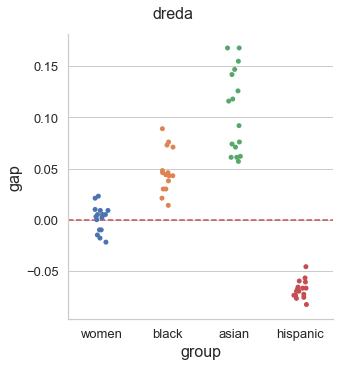

In [28]:
# df.plot.kde(x="seed", y="all")
# df.sort_values(by=["all"], ascending=False)
max_val = df["all"].max()
epsilon = 0.01
f_star = df[df["all"] >= (max_val-epsilon)] 
print(max_val)
print(len(f_star))
# f_star
# f_star.plot.kde(x="seed", y="all")
plot_minority_gaps(f_star,"dreda")

In [32]:
dataset="IHM"
dataset="mini-"+dataset
CLASSIFIER="torch"
PLOT_METRIC="auroc"
TUNE_METRIC="auroc"
Z = run_analyses(INPUT_PATH, dataset, FEATURES_PATH, MODEL, OUTPUT_PATH, TMP_PATH, 
             clear_results=False, tuning=False, metric=TUNE_METRIC)
# plot_analyses(OUTPUT_PATH, dataset, MODEL, dataset, plot_metric=PLOT_METRIC, tune_metric=TUNE_METRIC)
Z

[train/test set size: 1000/1000]
[running 2 torch classifier]
[reading cached features]
[subgroup: M | tr: 561 | ts: 545 | val: 556]
[subgroup: F | tr: 439 | ts: 455 | val: 444]
[subgroup: WHITE | tr: 711 | ts: 686 | val: 700]
[subgroup: BLACK | tr: 94 | ts: 104 | val: 103]
[subgroup: ASIAN | tr: 23 | ts: 11 | val: 23]
[subgroup: HISPANIC | tr: 25 | ts: 29 | val: 37]
skipped seed: 2201x2201
skipped seed: 2201x9325
skipped seed: 2201x1033
skipped seed: 2201x4179
skipped seed: 9325x2201
skipped seed: 9325x9325
skipped seed: 9325x1033
skipped seed: 9325x4179
skipped seed: 1033x2201
skipped seed: 1033x9325
skipped seed: 1033x1033
skipped seed: 1033x4179
skipped seed: 4179x2201
skipped seed: 4179x9325
skipped seed: 4179x1033
skipped seed: 4179x4179


,seed,all,men,women,white,black,asian,hispanic
0,2201x2201,0.794,0.785,0.803,0.786,0.852,0.944,0.964
1,2201x9325,0.784,0.767,0.800,0.779,0.845,0.944,0.964
2,2201x1033,0.807,0.822,0.790,0.805,0.829,0.944,0.964
3,2201x4179,0.796,0.787,0.806,0.789,0.852,0.944,0.964
4,9325x2201,0.786,0.815,0.754,0.785,0.793,1.000,0.464
5,9325x9325,0.791,0.817,0.762,0.789,0.832,1.000,0.464
6,9325x1033,0.776,0.795,0.755,0.766,0.806,1.000,0.464
7,9325x4179,0.779,0.795,0.759,0.767,0.832,1.000,0.464
8,1033x2201,0.755,0.747,0.761,0.753,0.743,0.944,0.446
9,1033x9325,0.746,0.733,0.758,0.739,0.740,0.944,0.446


In [ ]:
dataset="IHM"
# dataset="mini-"+dataset
CLASSIFIER="torch"
PLOT_METRIC="auroc"
TUNE_METRIC="auroc"
Z = run_analyses(INPUT_PATH, dataset, FEATURES_PATH, MODEL, OUTPUT_PATH, None, 
             clear_results=False, tune_metric=TUNE_METRIC, plot_metric=PLOT_VAR, fairness=True)
plot_analyses(OUTPUT_PATH, dataset, MODEL, dataset, plot_metric=PLOT_METRIC, tune_metric=TUNE_METRIC)


In [ ]:
CLASSIFIER="torch"
# run_analyses(INPUT_PATH, dataset, FEATURES_PATH, MODEL, OUTPUT_PATH, None, clear_results=False, tune_metric=None, subsample=False, plots=True)
plot_analyses(OUTPUT_PATH, dataset, MODEL, dataset, tune_metric=None)

In [ ]:
plot_performances(INPUT_PATH+"tasks.txt", MODEL, OUTPUT_PATH, mini_tasks=False, plot_metric=PLOT_VAR, tune_metric=None)

In [12]:
#Run tasks
CLASSIFIER="torch"
PLOT_METRIC="auroc"
TUNE_METRIC="auroc"
run_tasks(INPUT_PATH, "tasks.txt", FEATURES_PATH, MODEL, OUTPUT_PATH, TMP_PATH, reset=True, 
           metric=TUNE_METRIC, tuning=False, mini_tasks=True)
# plot_tasks(INPUT_PATH+"tasks.txt", MODEL, OUTPUT_PATH, mini_tasks=False, plot_metric=PLOT_VAR, tune_metric=None)

ing: 137 epochs]
 > seed: 4179x4179
[early stopping: 130 epochs]
******** Congestive heart failure; nonhypertensive mini-CHFN ********
[train/test set size: 1000/1000]
[running 2 torch classifier]
[reading cached features]
[subgroup: M | tr: 532 | ts: 592 | val: 561]
[subgroup: F | tr: 468 | ts: 408 | val: 439]
[subgroup: WHITE | tr: 698 | ts: 735 | val: 739]
[subgroup: BLACK | tr: 91 | ts: 78 | val: 86]
[subgroup: ASIAN | tr: 27 | ts: 13 | val: 26]
[subgroup: HISPANIC | tr: 32 | ts: 27 | val: 29]
 > seed: 2201x2201
[early stopping: 21 epochs]
 > seed: 2201x9325
[early stopping: 21 epochs]
 > seed: 2201x1033
[early stopping: 21 epochs]
 > seed: 2201x4179
[early stopping: 21 epochs]
 > seed: 9325x2201
[early stopping: 167 epochs]
 > seed: 9325x9325
[early stopping: 156 epochs]
 > seed: 9325x1033
[early stopping: 148 epochs]
 > seed: 9325x4179
[early stopping: 152 epochs]
 > seed: 1033x2201
[early stopping: 29 epochs]
 > seed: 1033x9325
[early stopping: 29 epochs]
 > seed: 1033x1033
[ear

In [17]:
RESULTS_PATH = BASE_PATH+"/DATA/results_clinical2/"
MODEL="BERT-POOL"
# (tasks_fname, feature_type, results_path, metric, mini_tasks=True)
plot_tasks(INPUT_PATH+"tasks.txt", MODEL, OUTPUT_PATH , metric=PLOT_VAR, mini_tasks=True)

ValueError: The truth value of a DataFrame is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

In [ ]:
TUNE_METRIC="auroc"
plot_gridsearch(GRID_OUTPUT_PATH, "DOLM", MODEL, TUNE_METRIC, "DOLM")
plot_gridsearch(GRID_OUTPUT_PATH, "DOLM", MODEL, TUNE_METRIC, "DOLM", delta=True)

In [ ]:
RESULTS_PATH = BASE_PATH+"/DATA/results_clinical_GRID/"
MODEL="CLINICALBERT-POOL"
TUNE_METRIC="auroc"
plot_gridsearches(INPUT_PATH+"tasks.txt", RESULTS_PATH, MODEL, False, TUNE_METRIC, subgroups=False) 